# AI WORKFLOW IN PRODUCTION :  Capstone Projects



Author : Pelani Malange
Date: 04 February 2020

# Part 1:  Assimilate the business scenario and articulate testable hypotheses.

### Business question to be answered 

Can business managers predict the revenue for following month based on previous , frequency and value purchased 

### Data  Ingestion

Find ideal data to address the business opportunity  and provide  clarification  on the rationale for needing specific data.

Requirement for Prediction:

1. Need  to know country , patterns of buying products in the country  (last purchased item, quantity, date, cost)
2. Follow business instructions  train on  10 countries with most revenue
3. Find a feature  for revenue inorder to predict  sales from previos quantity sold and unit price



## Create a python script to extract relevant data from multiple data sources, automating the process of data ingestion.

In [47]:
%%writefile ./runtime/cs_data_ingestor.py
# The line above create a file called "cs_data_ingestor.py" in the  runtime  working
# directory and write the the reste of the cell in this file.

import json
import os
import sys
import getopt
import re
import shutil
import time
import pickle
from collections import defaultdict
from datetime import datetime
import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
## For plotting
import matplotlib.pyplot as plt## For outliers detection

data_dir = ""
DATA_DIR1 = os.path.join(".","data","cs-train")
DATA_DIR2 = os.path.join(".","data")
DATA_DIRP = os.path.join(".","data","cs-production")
IMAGE_DIR = os.path.join(".","images")


plt.style.use('seaborn')

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

#code adopted from solution guidance 
def fetch_data(data_dir):
    """
    load all json formatted files into a dataframe
    """

    ## input testing
    if not os.path.isdir(data_dir):
        raise Exception("specified data dir does not exist")
    if not len(os.listdir(data_dir)) > 0:
        raise Exception("specified data dir does not contain any files")

    file_list = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if re.search("\.json",f)]
    correct_columns = ['country', 'customer_id', 'day', 'invoice', 'month',
                       'price', 'stream_id', 'times_viewed', 'year']

    ## read data into a temp structure
    all_months = {}
    for file_name in file_list:
        df = pd.read_json(file_name)
        all_months[os.path.split(file_name)[-1]] = df

    ## ensure the data are formatted with correct columns
    for f,df in all_months.items():
        cols = set(df.columns.tolist())
        if 'StreamID' in cols:
             df.rename(columns={'StreamID':'stream_id'},inplace=True)
        if 'TimesViewed' in cols:
            df.rename(columns={'TimesViewed':'times_viewed'},inplace=True)
        if 'total_price' in cols:
            df.rename(columns={'total_price':'price'},inplace=True)

        cols = df.columns.tolist()
        if sorted(cols) != correct_columns:
            raise Exception("columns name could not be matched to correct cols")

    ## concat all of the data
    df = pd.concat(list(all_months.values()),sort=True)
    years,months,days = df['year'].values,df['month'].values,df['day'].values 
    dates = ["{}-{}-{}".format(years[i],str(months[i]).zfill(2),str(days[i]).zfill(2)) for i in range(df.shape[0])]
    df['invoice_date'] = np.array(dates,dtype='datetime64[D]')
    df['invoice'] = [re.sub("\D+","",i) for i in df['invoice'].values]
    df["revenue"] = df["times_viewed"]*df["price"]
    
    ## sort by date and reset the index
    df.sort_values(by='invoice_date',inplace=True)
    df.reset_index(drop=True,inplace=True)
    
    #export file 
   
    
    return(df)


def filter_data(df):
    ## find the top ten countries (wrt revenue)
    
    print("\n Imported data  with the following attrbutes \n")
    df.info()
    columns_to_show = ["revenue"]
    df_agg= df.groupby(['country'])[columns_to_show].sum().round(3).sort_values(['revenue'],ascending=False)
    #df.sort_values([''])
    #top10 = df_agg.sort_values(['price'],ascending=False).groupby('country').head(10)
    print("\nTop 10 countries to use \n{}".format("-"*15))
    
    top10 = df_agg.head(n=10)
    print(top10.index.unique())
    print("Filtering data based on top 10 countries to train model")
    df_top10 = df[df.country.isin(top10.index.unique())]
    print(df_top10.head(n=10))
    return df_top10



def update_target(target_file,df_clean, overwrite=False):
    """
    update line by line in case data are large
    """

    if overwrite or not os.path.exists(target_file):
        df_clean.to_csv(target_file, index=False)   
    else:
        df_clean.to_csv(target_file, mode='a', header=False, index=False)


def create_plot(df):
    fig = plt.figure(figsize=(14,6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    table1 = pd.pivot_table(df, index='country', columns='year', values='price',aggfunc='mean').round(3)
    table1.plot(kind='bar', ax=ax1)
    ax1.set_ylabel("Average price");

    table2 = pd.pivot_table(df, index='country', columns='year', values="revenue",aggfunc='sum').round(3)
    table2.plot(kind='bar', ax=ax2)
    ax2.set_ylabel("Total revenue viewership");

    ## adjust the axis to accomadate the legend
    ax1.set_ylim((0,9.3))
    ax2.set_ylim((0,1.3))
    image_path = os.path.join(IMAGE_DIR,"revenue.png")
    plt.savefig(image_path,bbox_inches='tight',pad_inches = 0,dpi=200)
    print("{} created.".format(image_path))

        


if __name__ == "__main__":
    
    

    ## collect args
    arg_string = "%s -c update "%sys.argv[0]
    try:
        optlist, args = getopt.getopt(sys.argv[1:],'c:')
    except getopt.GetoptError:
        print(getopt.GetoptError)
        raise Exception(arg_string)

    ## handle args
    #streams_file = None
    
    #db_file = None
    mode_exec = None
    for o, a in optlist:
        if o == '-c':
            mode_exec = a
            
    if mode_exec == "train":
        data_dir  = DATA_DIR1
    else:
        data_dir = DATA_DIRP
    
    
    df_raw =fetch_data(data_dir)
    print("\n Data information after import\n{}".format("-"*15))
    print(df_raw.info())
    print(df_raw.describe())
    
    print("\n Number of of days \n {}",df_raw["invoice_date"].max() - df_raw["invoice_date"].min())
    print("\ndf_raw before cleaning \n{}".format("-"*15))
    print(df_raw.isnull().sum(axis = 0))
    
    print("\n Data after cleaning")
    columns = ['country', 'day','month', 'price',  'times_viewed','year','invoice_date','revenue']
    df_analysis= df_raw[columns]
    print("\n df_analysis \n")
    create_plot(df_analysis)
    print ("\nFinal data for analysis\n{}".format("-"*15))
    print (df_analysis.info())
    
    print("Data with 10 countries for analysis \n{}",df_analysis.head(n=10))
    
    #update_target(os.path.join(data_dir2,'customer-data.csv'),df_analysis,overwrite=True)
    #print('\nCreated  file customer-data.csv')
    
         
    
    #filter training data based on top 10 countries
    
    df10 = filter_data(df_analysis)
    #save the data for  later use in  model training and testing 
    if mode_exec =="train":
        update_target(os.path.join(DATA_DIR2,'top10countries-data.csv'),df10,overwrite=True)
        print('\n Created  top10country-data.csv  for training in ./data folder \n' )
    else:
        update_target(os.path.join(DATA_DIR2,'updtop10countries-data.csv'),df10,overwrite=True)
        print('\n  Created  uptop10countries-data.csv to simulate production data in ./data folder \n')

    
    #convert invoice_date to string first before sending as json 
    
    #data.txt and text.txt are used for  testing apis
    #df10["invoice_date"] = df10["invoice_date"].dt.strftime("%d/%m/%Y")
    df10["invoice_date"] = df10["invoice_date"].astype(str)
    df10.to_json (os.path.join(DATA_DIR2,r'data.txt'), orient='split')
    df_test = df10.head(n=100)
    update_target(os.path.join(DATA_DIR2,'test.txt'),df_test,overwrite=True)
  

    
#pd.pivot_table(df, index= ['country','year'], values=columns_to_show,aggfunc='mean').round(3)


Overwriting ./runtime/cs_data_ingestor.py


In [48]:
!python3 ./runtime/cs_data_ingestor.py -c train


 Data information after import
---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815011 entries, 0 to 815010
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   country       815011 non-null  object        
 1   customer_id   625249 non-null  float64       
 2   day           815011 non-null  int64         
 3   invoice       815011 non-null  object        
 4   month         815011 non-null  int64         
 5   price         815011 non-null  float64       
 6   stream_id     815011 non-null  object        
 7   times_viewed  815011 non-null  int64         
 8   year          815011 non-null  int64         
 9   invoice_date  815011 non-null  datetime64[ns]
 10  revenue       815011 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(4), object(3)
memory usage: 68.4+ MB
None
         customer_id            day  ...           year        revenue
count  625249.000000

# Investigate the relationship between the relevant data, the target and the business metric.

### 1. Trend Analysis

df: 801773 x 7

  Check first 4 rows

                day  month  price  times_viewed  year invoice_date  revenue
country                                                                    
United Kingdom   28     11   5.95             1  2017   2017-11-28     5.95
United Kingdom   28     11   6.75            12  2017   2017-11-28    81.00
United Kingdom   28     11   2.10            21  2017   2017-11-28    44.10
United Kingdom   28     11   1.25             5  2017   2017-11-28     6.25
./images/raw_ts.png created.


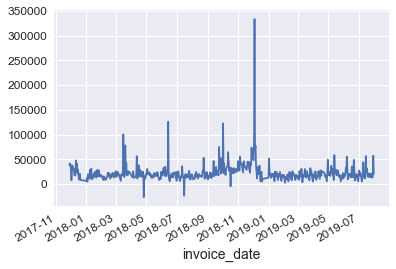

<Figure size 1080x360 with 0 Axes>

In [3]:
#%% create a new time series trend analysis of the data

#%%writefile timeseries_eda.py
import os
import re
import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
## For plotting
import matplotlib.pyplot as plt## For outliers detection
from sklearn import preprocessing, svm## For stationarity test and decomposition
import statsmodels.tsa.api as smt
import statsmodels.api as sm

plt.style.use('seaborn')
%matplotlib inline

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16

## specify the directory you saved the data and images in
DATA_DIR = os.path.join(".","data")
IMAGE_DIR = os.path.join(".","images")

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

def save_plot(image_name):
    image_path = os.path.join(IMAGE_DIR,image_name)
    plt.savefig(image_path,bbox_inches='tight',pad_inches = 0,dpi=200)
    print("{} created.".format(image_path))

def fetch_data():
    df = pd.read_csv(os.path.join(DATA_DIR, "top10countries-data.csv"),index_col=0, parse_dates=['invoice_date'])
    print("df: {} x {}".format(df.shape[0], df.shape[1]))
    ## check the first few rows
    print("\n  Check first 4 rows\n")
    print(df.head(n=4))
    
    return df 

df = fetch_data()
## format datetime column
df["invoice_date"] = pd.to_datetime(df['invoice_date'], format='%d.%m.%Y')## create time series
ts = df.groupby("invoice_date")["revenue"].sum().rename("sales")
ts.head()
#ts.tail()
ts.plot()
plt.figure(figsize=(15,5))
save_plot("raw_ts.png")



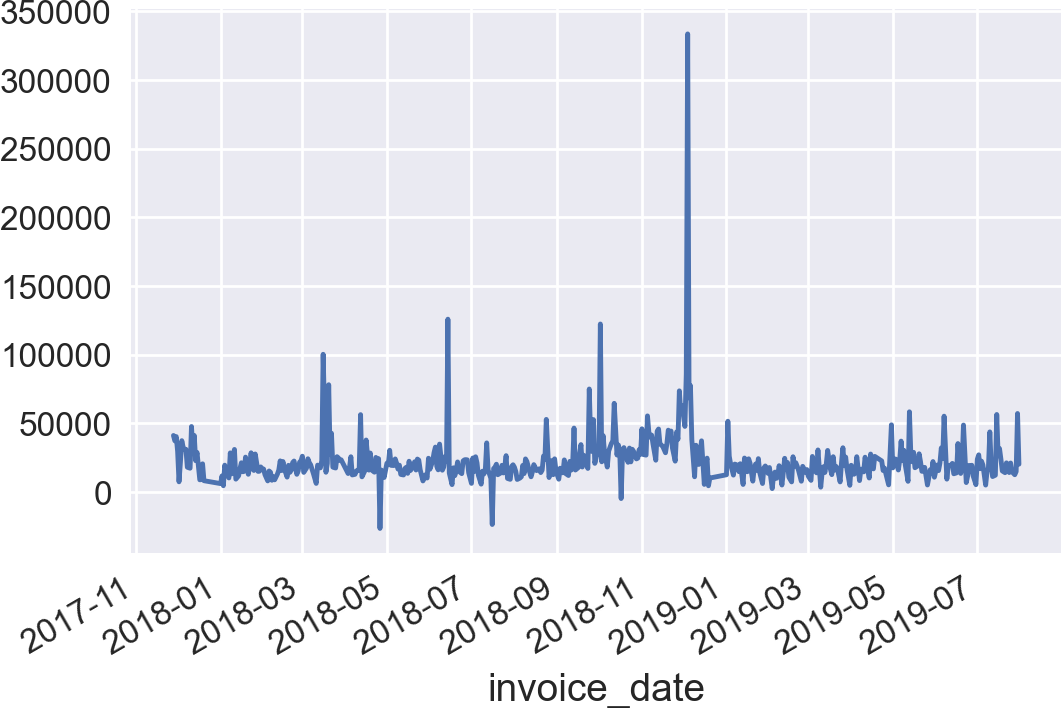

In [113]:
'''

df: 801773 x 7

  Check first 4 rows

                day  month  price  times_viewed  year invoice_date  revenue
country                                                                    
United Kingdom   28     11   5.95             1  2017   2017-11-28     5.95
United Kingdom   28     11   6.75            12  2017   2017-11-28    81.00
United Kingdom   28     11   2.10            21  2017   2017-11-28    44.10
United Kingdom   28     11   1.25             5  2017   2017-11-28     6.25
./images/raw_ts.png created.
'''

Image("./images/raw_ts.png",width=600, height=300)

1. The spike in 2018 March,  May, June, July , Oct, Dec   seems to be an outlier that can affect the machine learnig algorithm, we need to identify algorithm that responds well to outliers .
2. More tests need to be done to pick up any trends 



In [5]:
'''
Plot ts with rolling mean and 95% confidence interval with rolling std.
:parameter    
  :param ts: pandas Series    
  :param window: num - for rolling stats
  :param plot_ma: bool - whether plot moving average
  :param plot_intervals: bool - whether plot upper and lower bounds
'''
def plot_ts(ts, plot_ma=True, plot_intervals=True, window=30,
            figsize=(15,5)):    
   rolling_mean = ts.rolling(window=window).mean()    
   rolling_std = ts.rolling(window=window).std()
   plt.figure(figsize=figsize)    
   plt.title(ts.name)    
   plt.plot(ts[window:], label='Actual values', color="black")    
   if plot_ma:        
      plt.plot(rolling_mean, 'g', label='MA'+str(window),
               color="red")    
   if plot_intervals:
      lower_bound = rolling_mean - (1.96 * rolling_std)
      upper_bound = rolling_mean + (1.96 * rolling_std)
   plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound,
                    color='lightskyblue', alpha=0.4)
   plt.legend(loc='best')
   plt.grid(True)
   plt.show()
   save_plot("rollingavg30days.png") 
    
def fit_trend(ts, degree=1, plot=True, figsize=(15,5)):
    ## fit trend
    df = ts.to_frame(name="ts")
    params = np.polyfit(ts.reset_index().index, ts.values, deg=degree)
    costant = params[-1]    
    df["trend"] = costant
    X = np.array(range(1,len(ts)+1))
    for i in range(1,degree+1):
        df["trend"] = df["trend"] + params[i-1]*(X**i)
        
    ## plot
    if plot is True:
        ax = df.plot(grid=True, title="Fitting Trend", figsize=figsize, color=["black","red"])
        ax.set(xlabel=None)
        plt.show()
    return df, params





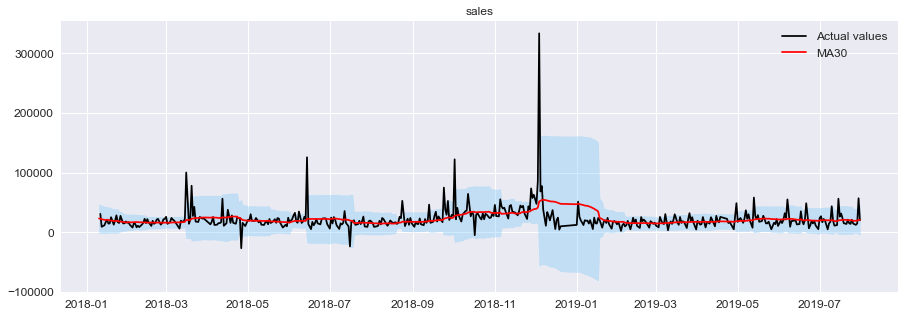

./images/rollingavg30days.png created.


<Figure size 432x288 with 0 Axes>

In [6]:
plot_ts(ts,window=30)

Plot of rolling window 30 days suggest theres are no trends in the data . Lets try to  add the rolling windows  to 365 days would suggest otherwise

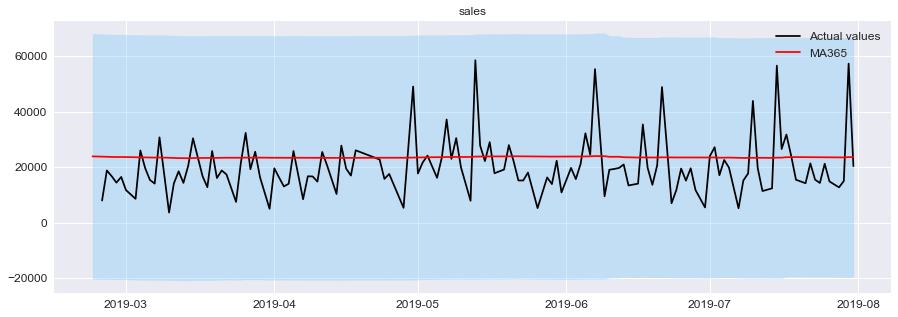

./images/rollingavg30days.png created.
./images/tsaverage365days.png created.


<Figure size 432x288 with 0 Axes>

In [35]:
plot_ts(ts,window=365)
save_plot("tsaverage365days.png")

Rolling window across the year shows that the price remains fairly flat.

# Outliers detection

In the bar chart plotted against price  , there were  clear outliers in the Hongkong ,Norway , Singapore data , lets understand what this means to the data 

./images/outhist.png created.


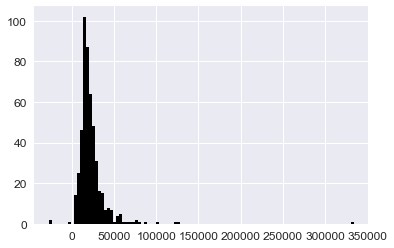

In [36]:
## Plot histogram
ts.hist(color="black", bins=100)
save_plot("outhist.png")

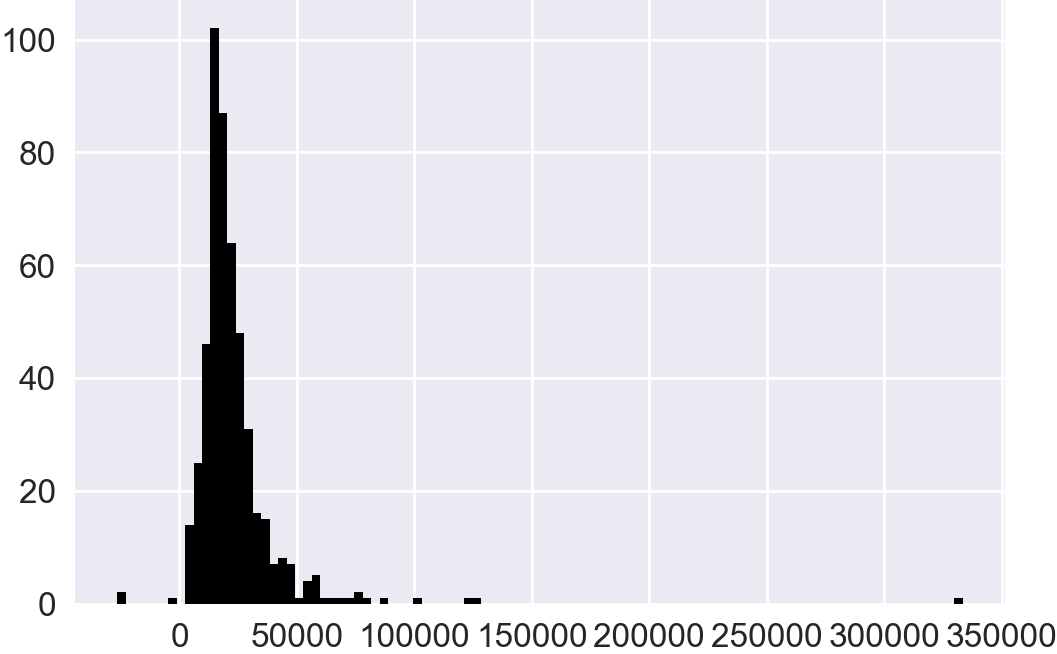

In [37]:
Image("images/outhist.png", width =600, height=300)

The above diagram seems to suggest a binomial distribution.  Box plot with all data 

./images/box_plotwithout.png created.


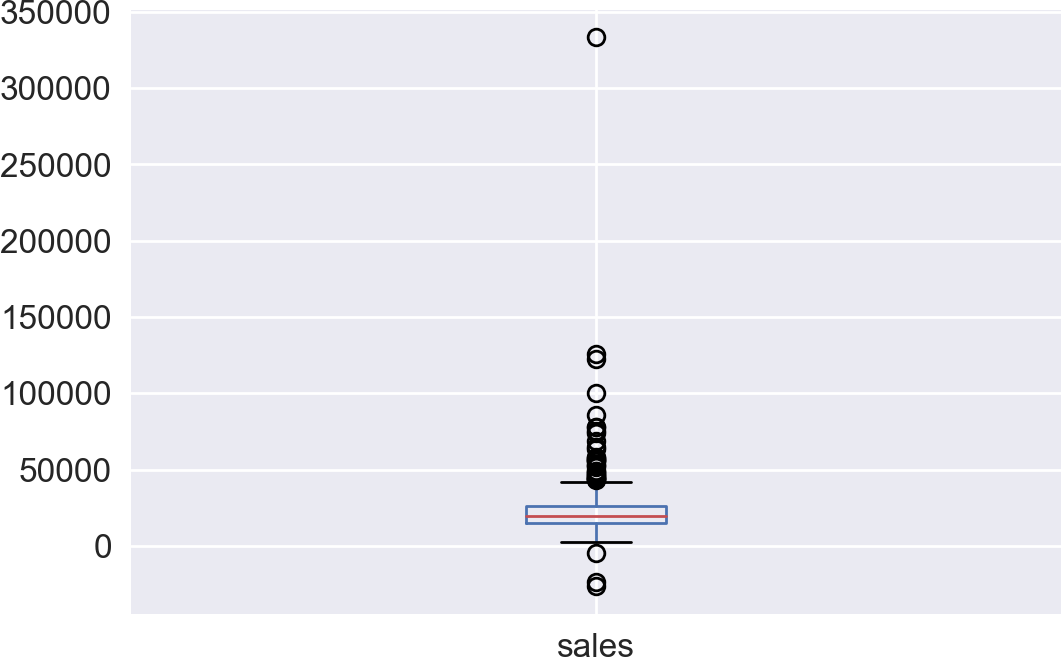

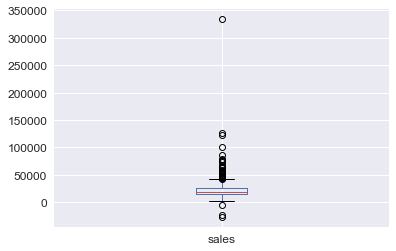

In [39]:
## Boxplot
#ts.plot.box(showfliers=False)
ts.plot.box()
save_plot("box_plotwithout.png")
Image("images/box_plotwithout.png", width =600, height=300)

./images/bxwithout_out.png created.


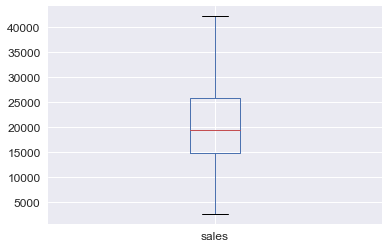

In [40]:
#Box plot without outliers
ts.plot.box(showfliers=False)
save_plot("bxwithout_out.png")

In [42]:
'''
Find outliers using sklearn unsupervised support vetcor machine.
:parameter
    :param ts: pandas Series
    :param perc: float - percentage of outliers to look for
:return
    dtf with raw ts, outlier 1/0 (yes/no), numeric index
'''
def find_outliers(ts, perc=0.01, figsize=(15,5)):
    ## fit svm
    scaler = preprocessing.StandardScaler()
    ts_scaled = scaler.fit_transform(ts.values.reshape(-1,1))
    model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
    model.fit(ts_scaled)    ## df output
    df_outliers = ts.to_frame(name="ts")
    df_outliers["index"] = range(len(ts))
    df_outliers["outlier"] = model.predict(ts_scaled)
    df_outliers["outlier"] = df_outliers["outlier"].apply(lambda
                                              x: 1 if x==-1 else 0)
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.set(title="Outliers detection: found"
           +str(sum(df_outliers["outlier"]==1)))
    ax.plot(df_outliers["index"], df_outliers["ts"],
            color="black")
    ax.scatter(x=df_outliers[df_outliers["outlier"]==1]["index"],
               y=df_outliers[df_outliers["outlier"]==1]['ts'],
               color='red')
    ax.grid(True)
    plt.show()
    return df_outliers

We need to remove the outliers  inorder to model time series properly

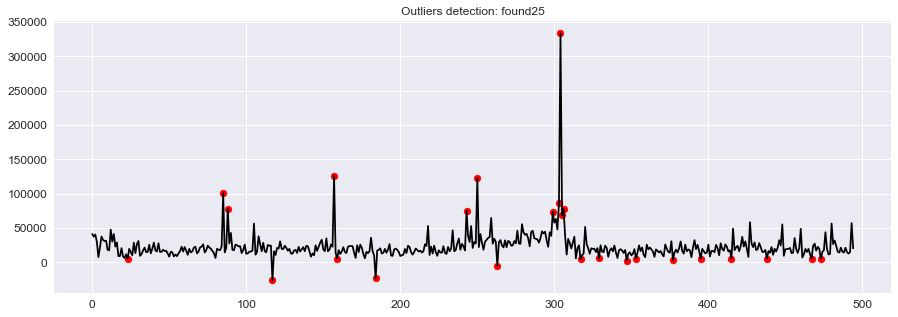

In [43]:
'''
Interpolate outliers in a ts.
'''
def remove_outliers(ts, outliers_idx, figsize=(15,5)):
    ts_clean = ts.copy()
    ts_clean.loc[outliers_idx] = np.nan
    ts_clean = ts_clean.interpolate(method="linear")
    ax = ts.plot(figsize=figsize, color="red", alpha=0.5,
         title="Remove outliers", label="original", legend=True)
    ts_clean.plot(ax=ax, grid=True, color="black",
                  label="interpolated", legend=True)
    plt.show()
    save_plot("outlier_detect.png")
    return ts_clean
df_outliers = find_outliers(ts, perc=0.05)


Remove outliers 

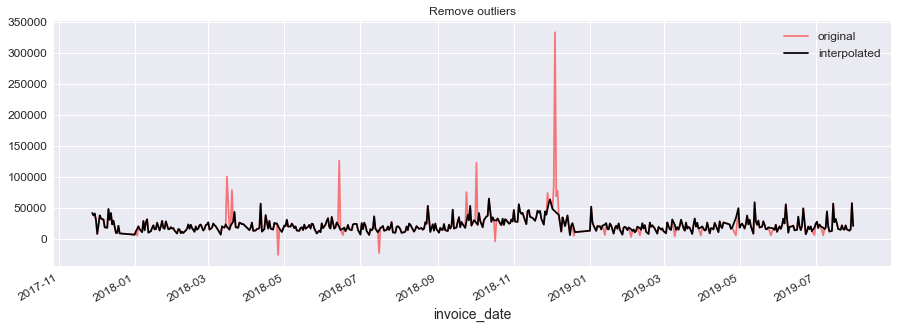

In [584]:
## outliers index position
outliers_index_pos = df_outliers[df_outliers["outlier"]==1].index## exclude outliers
ts_clean = remove_outliers(ts, outliers_idx=outliers_index_pos)

For the sake of training, I will proceed with outliers included in the trainig. Maintain the original data frame

 Test for stationary data using  Dickey-Fuller test (also called “ADF test”) where the null hypothesis is that the time series has a unit root, in other words, that the time series is not stationary. 

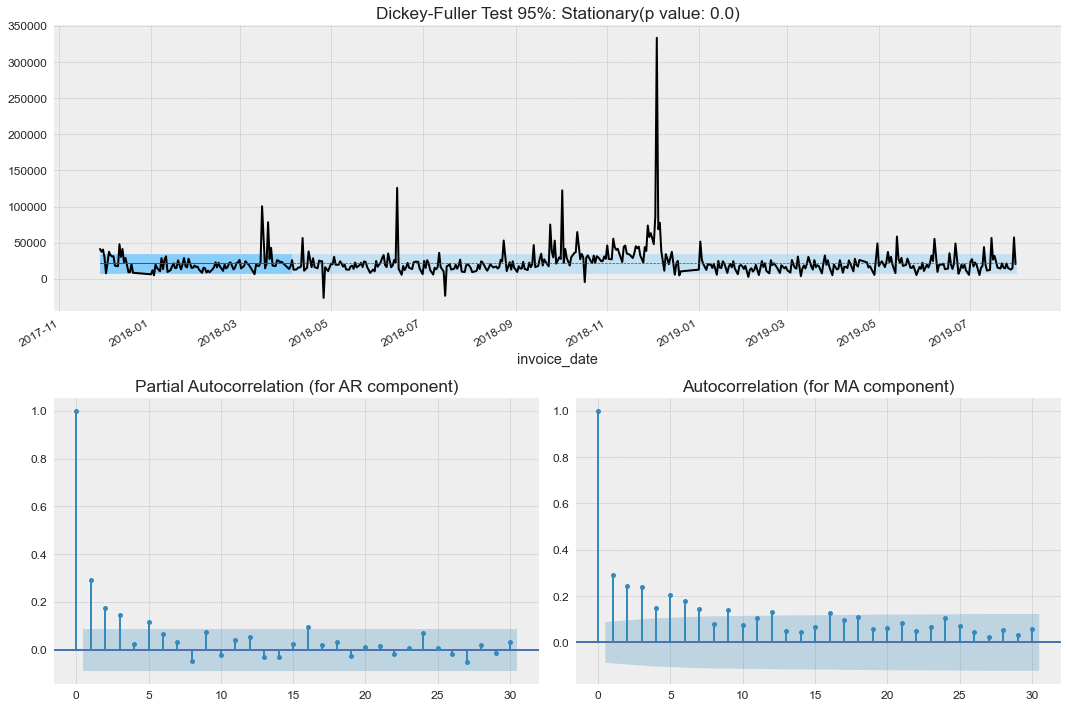

In [585]:
'''
Test stationarity by:
    - running Augmented Dickey-Fuller test wiht 95%
    - plotting mean and variance of a sample from data
    - plottig autocorrelation and partial autocorrelation
'''
def test_stationarity_acf_pacf(ts, sample=0.20, maxlag=30, figsize= 
                              (15,10)):
    with plt.style.context(style='bmh'):
        ## set figure
        fig = plt.figure(figsize=figsize)
        ts_ax = plt.subplot2grid(shape=(2,2), loc=(0,0), colspan=2)
        pacf_ax = plt.subplot2grid(shape=(2,2), loc=(1,0))
        acf_ax = plt.subplot2grid(shape=(2,2), loc=(1,1))
        
        ## plot ts with mean/std of a sample from the first x% 
        df_ts = ts.to_frame(name="ts")
        sample_size = int(len(ts)*sample)
        df_ts["mean"] = df_ts["ts"].head(sample_size).mean()
        df_ts["lower"] = df_ts["ts"].head(sample_size).mean() + df_ts["ts"].head(sample_size).std()
        df_ts["upper"] = df_ts["ts"].head(sample_size).mean() - df_ts["ts"].head(sample_size).std()
        df_ts["ts"].plot(ax=ts_ax, color="black", legend=False)
        df_ts["mean"].plot(ax=ts_ax, legend=False, color="red",linestyle="--", linewidth=0.7)
        ts_ax.fill_between(x=df_ts.index, y1=df_ts['lower'], y2=df_ts['upper'], color='lightskyblue', alpha=0.4)
        df_ts["mean"].head(sample_size).plot(ax=ts_ax,legend=False, color="red", linewidth=0.9)
        ts_ax.fill_between(x=df_ts.head(sample_size).index, \
                           y1=df_ts['lower'].head(sample_size), \
                           y2=df_ts['upper'].head(sample_size),\
                           color='lightskyblue')
        
        ## test stationarity (Augmented Dickey-Fuller)
        adfuller_test = sm.tsa.stattools.adfuller(ts, maxlag=maxlag,autolag="AIC")
        adf, p, critical_value = adfuller_test[0], adfuller_test[1], adfuller_test[4]["5%"]
        p = round(p, 3)
        conclusion = "Stationary" if p < 0.05 else "Non-Stationary"
        ts_ax.set_title('Dickey-Fuller Test 95%: '+conclusion+ '(p value: '+str(p)+')')
        
        ## pacf (for AR) e acf (for MA) 
        smt.graphics.plot_pacf(ts, lags=maxlag, ax=pacf_ax,title="Partial Autocorrelation (for AR component)")
        smt.graphics.plot_acf(ts, lags=maxlag, ax=acf_ax,title="Autocorrelation (for MA component)")
        plt.tight_layout()
test_stationarity_acf_pacf(ts, sample=0.20, maxlag=30)

From results above, my data is stationary  with p value at 95% and 99%. However at closer look on the graph,  the time series has deviated downwards from the mean expect for November 2018 where it came close, so inorder to fix this by running the same tests after differencing the time series. According to theory of differencing ,   differencing can help stabilize the mean by removing changes in the level of observations, and therefore eliminating (or reducing) trend and seasonality (towardsdatascience, 2020)

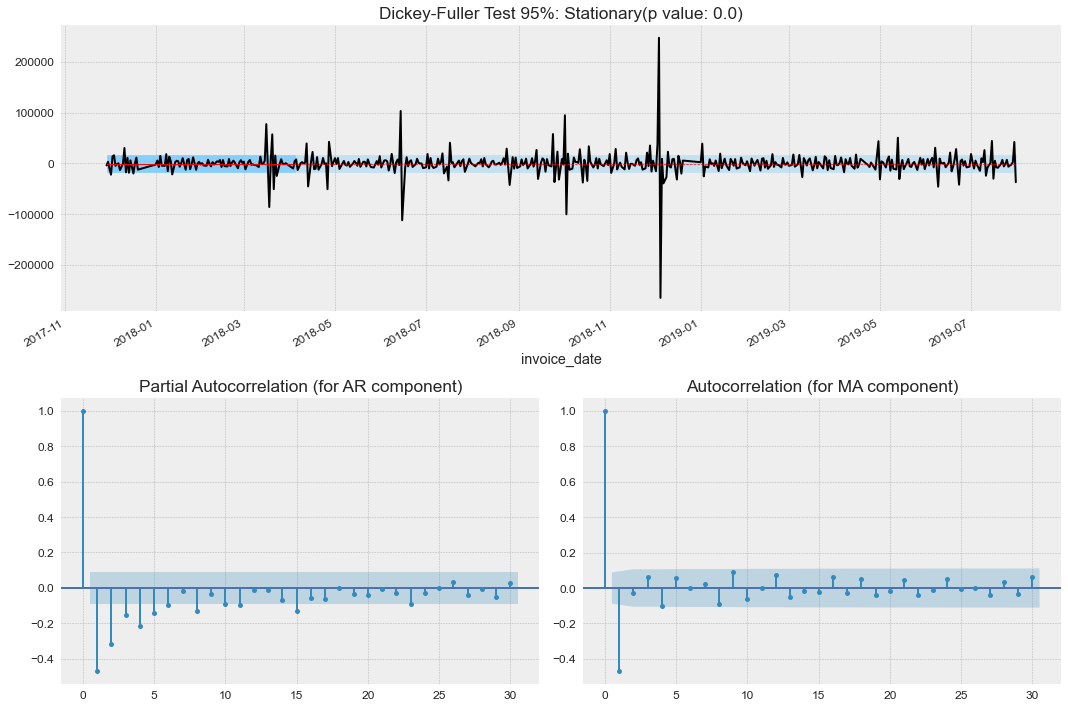

In [586]:
diff_ts = ts - ts.shift(1)
diff_ts = diff_ts[(pd.notnull(diff_ts))]
test_stationarity_acf_pacf(diff_ts, sample=0.20, maxlag=30)


The Auto correlation shows a negative pattern at beginning of the week, ,picksup mid -week , drops before picing again in 7 days. This shows seasonality of 7 days 
This could suggest people like to use services towards weekend and immediately after. 

In following activity , I will  decompose the seasonality before using ARIMA library

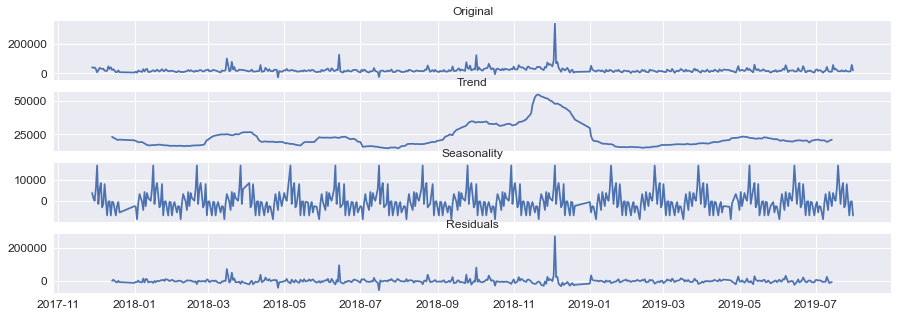

In [587]:
decomposition = smt.seasonal_decompose(ts, period=30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid   
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, sharey=False, figsize=(15,5))
ax[0].plot(ts)
ax[0].set_title('Original')
ax[0].grid(True) 
ax[1].plot(trend)
ax[1].set_title('Trend')
ax[1].grid(True)  
ax[2].plot(seasonal)
ax[2].set_title('Seasonality')
ax[2].grid(True)  
ax[3].plot(residual)
ax[3].set_title('Residuals')
ax[3].grid(True)
pass

# Part 2  Model Building and Selection

Tasks

    1. State the different modeling approaches that you will compare to address the business opportunity.

    2. Iterate on your suite of possible models by modifying data transformations, pipeline architectures,        hyperparameters and other relevant factors.

    3. Re-train your model on all of the data using the selected approach and prepare it for deployment. Articulate your findings in a summary report.



### Trend analysis Modeling approach to use

First we shall analyse the time series data for conformity


In [9]:
#%% create a new time series trend analysis of the data

#%%writefile timeseries_eda.py
import os
import re
import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
## For plotting
import matplotlib.pyplot as plt## For outliers detection
from sklearn import preprocessing, svm## For stationarity test and decomposition
import statsmodels.tsa.api as smt
import statsmodels.api as sm

plt.style.use('seaborn')
%matplotlib inline

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16

## specify the directory you saved the data and images in
DATA_DIR = os.path.join(".","data")
IMAGE_DIR = os.path.join(".","images")

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

#function to save images
def save_plot(image_name):
    image_path = os.path.join(IMAGE_DIR,image_name)
    plt.savefig(image_path,bbox_inches='tight',pad_inches = 0,dpi=200)
    print("{} created.".format(image_path))

def fetch_data():
    df = pd.read_csv(os.path.join(DATA_DIR, "top10countries-data.csv"),index_col=0, parse_dates=['invoice_date'])
    print("df size : {} x {}".format(df.shape[0], df.shape[1]))
    
    return df 

## format datetime column
df = fetch_data()
df["invoice_date"] = pd.to_datetime(df['invoice_date'], format='%d.%m.%Y')## create time series
ts = df.groupby("invoice_date")["revenue"].sum().rename("Sales")
#data does not have daily sales so for the model, it will be analysed based on  monthly averages
y_ts = ts.resample('MS').mean()

#ts.tail()

df size : 801773 x 7


timeseries  with monthly average revenues

 Show daily time series trend



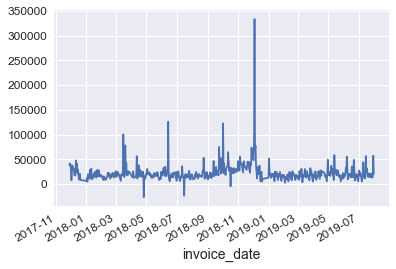

./images/dailyts.png created.

 Show Monthly time series trend 



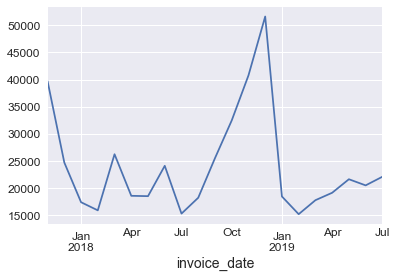

./images/monthly.png created.


<Figure size 432x288 with 0 Axes>

In [10]:
print("timeseries  with monthly average revenues".format( y_ts.shape[0]))
y_ts.head()


print("\n Show daily time series trend\n")
ts.plot()
plt.show()
save_plot("dailyts.png")

print("\n Show Monthly time series trend \n")
y_ts.plot()
plt.show()
save_plot("monthly.png")


Quarterly trend shows sales declining in Jan 2018 and picking up from mid Jul 2018.

As typical of time series data, the data points through simple feature reduction is small. Which will require algorithm that are advanced to forecast based on the moving averages .

The spike in Dec 2018 seems to be an outlier that can affect the machine learnig algorithm, we need to identify algorithm that responds well to outliers . More tests need to be done to pick up any trends


# Test for hyper parameters using auto arima in the times series

Auto_arima() uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC

One of the requirements for ARIMA is that the time series should be stationary. A stationary series is one where the properties do not change over time. There are several methods to check the stationarity of a series. The one you’ll use in this guide is the Augmented Dickey-Fuller test. Test for stationry before proceeding with tests. 

In [61]:
from statsmodels.tsa.stattools import adfuller
print("p-value:", adfuller(y_ts)[1])

p-value: 0.029955476715040872


P-value is below 0.05 so it fits for ARIMA tests  using average revenue feature , 
with auto-arima, the best hyperparameters will be predicted

In [14]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


model = pm.auto_arima(y_ts, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality, not enough data to cross 24 months period 
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)



Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=421.525, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=420.264, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=419.694, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.335 seconds


In [13]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   21
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -208.847
Date:                Thu, 04 Feb 2021   AIC                            419.694
Time:                        15:12:18   BIC                            420.638
Sample:                             0   HQIC                           419.854
                                 - 21                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.859e+08   3.48e+07      5.343      0.000    1.18e+08    2.54e+08
Ljung-Box (L1) (Q):                   4.10   Jarque-Bera (JB):                13.77
Prob(Q):                              0.04   Pr

### Preliminary model analysis

ARIMA time series use AIC ,BIC value for assessment . In this instance, hyper parameter  shows  Best model: ARIMA(0,2,0)(0,0,0)[0].  AIC stands for Akaike Information Criterion, which estimates the relative amount of information lost by a given model. In simple terms, a lower AIC value is preferred. In the above output, the lowest AIC value of 419.694 was obtained for the ARIMA(0, 2, 0) model, and that is used as the final estimator.

But we shall further optimise the model to have lower AIC value


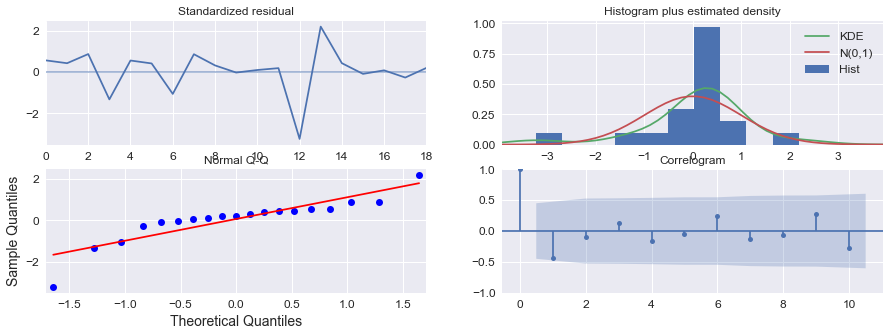

./images/arimaplot_diag created.


<Figure size 432x288 with 0 Axes>

In [63]:
model.plot_diagnostics(figsize=(15,5))
plt.show()
save_plot("arimaplot_diag")

## Conclusion of EDA

    1.Standard residual revolves around mean O
    2. Histogram suggests the values center on mean zero and follows normal distribution
    3. There is no much deviation from the main red line
    4. The residual errors are not auto correlated, no further tests required .

Conclusion, y_ts values seem a good fit done using Auto Arima . So we proceed with forecasting and optimisation.


### Forecasting

In [16]:
from dateutil.relativedelta  import *
from datetime import timedelta


# Forecast
n_periods = 10

start = len(y_ts)
end = start+ n_periods

print(start, end)

fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(start, end)
                        
# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)


21 31


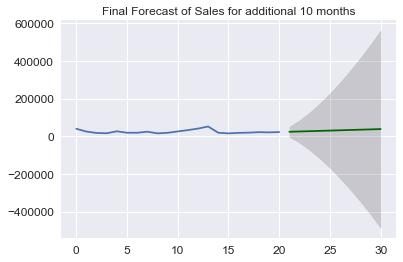

./images/arimaplot_ns.png created.


<Figure size 432x288 with 0 Axes>

In [17]:
# Plot
plt.plot(y_ts.values)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title("Final Forecast of Sales for additional 10 months")
plt.show()
save_plot("arimaplot_ns.png")

Using plots , we shall test for  differention Plot seasonal differentiation if any 

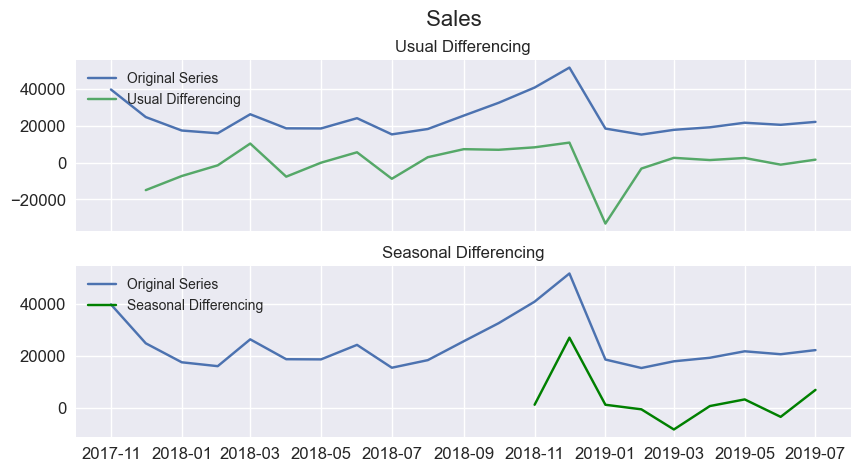

./images/seasonal_diff created.


<Figure size 432x288 with 0 Axes>

In [19]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(y_ts[:], label='Original Series')
axes[0].plot(y_ts[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(y_ts[:], label='Original Series')
axes[1].plot(y_ts[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle(' Sales', fontsize=16)
plt.show()
save_plot("seasonal_diff")

Looking the seasonal differentiation, even though we have 21 months in stead on 24, we ses that introducing differentiation of 12 months makes the data more stationary , revolving around 0 . So we shall optimse the algorithm further in the next steps

### Seasonality

Although the model fit well , we shall optimise but introducing seasonal factors in from Moving average (MA). Please refer to ARIMA formual for moving average part . It is not part of this exercise.


In [20]:
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA

# Seasonal - fit stepwise auto-ARIMA

#pm.auto_arima 
smodel = pm.auto_arima(y_ts, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)




model_fit = smodel.fit(y_ts,disp=0)


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,1,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=163.441, Time=0.02 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=157.073, Time=0.08 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(1,2,0)(0,1,0)[12]             : AIC=155.075, Time=0.02 sec
 ARIMA(1,2,0)(0,1,1)[12]             : AIC=157.074, Time=0.04 sec
 ARIMA(1,2,0)(1,1,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(2,2,0)(0,1,0)[12]             : AIC=154.754, Time=0.03 sec
 ARIMA(2,2,0)(1,1,0)[12]             : AIC=156.725, Time=0.06 sec
 ARIMA(2,2,0)(0,1,1)[12]             : AIC=156.725, Time=0.05 sec
 ARIMA(2,2,0)(1,1,1)[12]             : AIC=158.718, Time=0.22 sec
 ARIMA(3,2,0)(0,1,0)[12]             : AIC=156.335, Time=0.07 sec
 ARIMA(2,2,1)(0,1,0)[12]             : AIC=156.218, Time=0.09 sec
 ARIMA(1,2,1)(0,1,0)[12]             : AIC=inf, Time=0.07 sec
 ARIMA(3,2,1)(0,1,0)[12]             : AIC=157.90

In [23]:
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   21
Model:             SARIMAX(2, 2, 0)x(0, 1, 0, 12)   Log Likelihood                 -74.377
Date:                            Thu, 04 Feb 2021   AIC                            154.754
Time:                                    15:17:29   BIC                            154.592
Sample:                                         0   HQIC                           152.749
                                             - 21                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9786      0.277     -3.528      0.000      -1.522      -0.435
ar.L2         -0.3231      0.249   

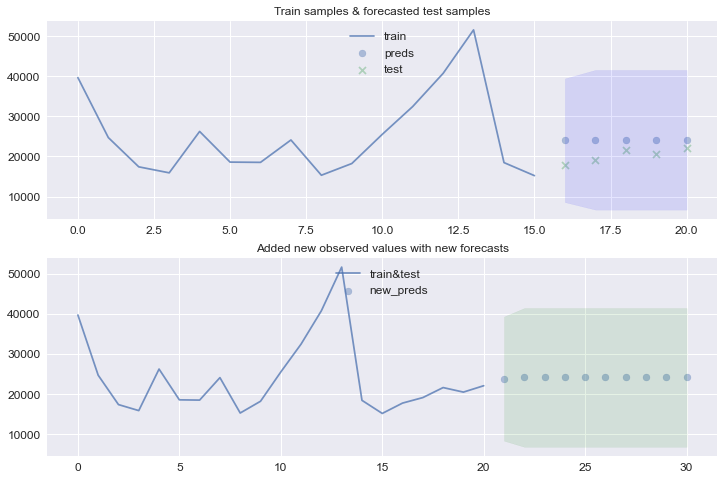

./images/pmdarima_analysis.png created.


<Figure size 432x288 with 0 Axes>

In [24]:
from pmdarima import model_selection
train, test = model_selection.train_test_split(y_ts, train_size=0.8)

# #############################################################################
# Fit with some validation (cv) samples
arima = pm.auto_arima(train, start_p=1, start_q=1, d=0, max_p=5, max_q=5,
                      out_of_sample_size=10, suppress_warnings=True,
                      stepwise=True, error_action='ignore')

# Now plot the results and the forecast for the test set
preds, conf_int = arima.predict(n_periods=test.shape[0],return_conf_int=True)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
x_axis = np.arange(train.shape[0] + preds.shape[0])
axes[0].plot(x_axis[:train.shape[0]], train, alpha=0.75,label='train')
axes[0].scatter(x_axis[train.shape[0]:], preds, alpha=0.4, marker='o',label='preds')
axes[0].scatter(x_axis[train.shape[0]:], test, alpha=0.4, marker='x',label='test')
axes[0].fill_between(x_axis[-preds.shape[0]:], conf_int[:, 0], conf_int[:, 1],alpha=0.1, color='b')
axes[0].legend(loc='upper center')

# fill the section where we "held out" samples in our model fit

axes[0].set_title("Train samples & forecasted test samples")

# Now add the actual samples to the model and create NEW forecasts
arima.update(test)
new_preds, new_conf_int = arima.predict(n_periods=10, return_conf_int=True)
new_x_axis = np.arange(y_ts.shape[0] + 10)

axes[1].plot(new_x_axis[:y_ts.shape[0]], y_ts, alpha=0.75,label='train&test')
axes[1].scatter(new_x_axis[y_ts.shape[0]:], new_preds, alpha=0.4, marker='o', label='new_preds')
axes[1].fill_between(new_x_axis[-new_preds.shape[0]:],
                     new_conf_int[:, 0],
                     new_conf_int[:, 1],
                     alpha=0.1, color='g')
axes[1].set_title("Added new observed values with new forecasts")
axes[1].legend(loc='upper center')
plt.show()
save_plot("pmdarima_analysis.png")

# Result of comparison of auto arima with or without seasonal trend

From graph above ,  its shows forecasting cannot be accurate but the confidence interval, it helps to predict values within a certain risk threshold. 

AIC value of 154.74 is lower than normal arima the 494 above . We shall use auto arima with seasonal trends SARIMA. Although we have ar.L2 p value of 0.195 which is higer than 0.05 and rendering the X  feature insignificant, we shall proceed with the suggested hyperparameters


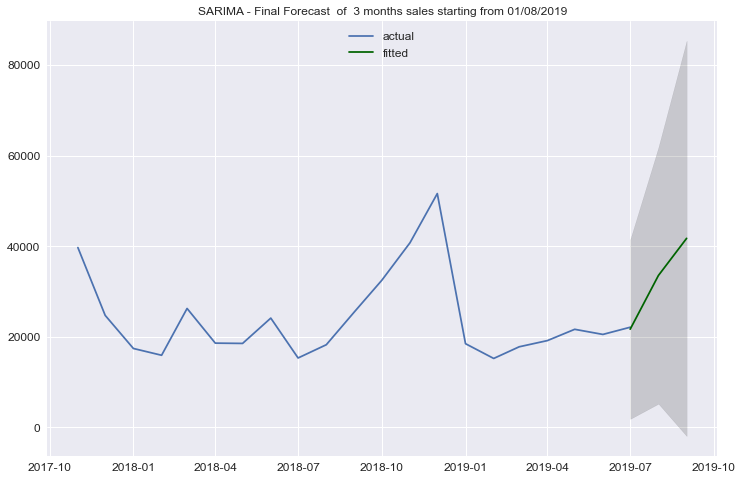

./images/arimasfc.png created.


<Figure size 432x288 with 0 Axes>

In [121]:
# Forecast
n_periods = 3
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(y_ts.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(12, 8))
plt.plot(y_ts, label ="actual")
plt.plot(fitted_series, color='darkgreen', label="fitted")
plt.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=.15)

plt.title("SARIMA - Final Forecast  of  3 months sales starting from 01/08/2019")
plt.legend(loc ="upper center")
plt.show()
save_plot("arimasfc.png")

# Part 2 conclusion

The data shall be modeled using monthly average inorder to account for some missing daily values , this doesnt offer much impact on ARIMA.

Auto arima and inclusion of seasonal trend shows better model performace and against none seasonal.

Scripts will be developed to model based on second SARIMA model

Seasonal index

SARIMAX with exogenous features depend on seaesonal index requires seasonal decompose , with current data limited to 21 months, it does not fulfill the requirements to decompose. So this will be skipped until we have more data




# Part 3: Modeling, testing , deployment into production 

In this section we show the prediction module

Automatically discover the optimal order for an ARIMA model.

The auto-ARIMA process seeks to identify the most optimal parameters for an ARIMA model, settling on a single fitted ARIMA model. This process is based on the commonly-used R function, forecast::auto.arima

Auto-ARIMA works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto-ARIMA also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

In order to find the best model, auto-ARIMA optimizes for a given information_criterion, one of (‘aic’, ‘aicc’, ‘bic’, ‘hqic’, ‘oob’) (Akaike Information Criterion, Corrected Akaike Information Criterion, Bayesian Information Criterion, Hannan-Quinn Information Criterion, or “out of bag”–for validation scoring–respectively) and returns the ARIMA which minimizes the value.

# Create scripts

1. logging 
2. python scripts for modeling offline 
3. Script for docker deployment 
4. Script for app predict, train , update and monitoring

The scripts are available as part of CS_PKJM notebook

1. Overwriting ./runtime/logger.py
2. Overwriting ./runtime/model.py
3. Overwriting ./runtime/app.py



In [165]:
%%writefile ./runtime/logger.py
"""
module with functions to enable logging
"""

import time,os,re,csv,sys,uuid,joblib
from datetime import date

if not os.path.exists(os.path.join(".","logs")):
    os.mkdir("logs")

def update_train_log(data_shape, eval_test, runtime, MODEL_VERSION, MODEL_VERSION_NOTE, test=False):
    """
    update train log file
    """

    ## name the logfile using something that cycles with date (day, month, year)    
    today = date.today()
    if test:
        logfile = os.path.join("logs", "train-test.log")
    else:
        logfile = os.path.join("logs", "train-{}-{}.log".format(today.year, today.month))
        
    ## write the data to a csv file    
    header = ['unique_id','timestamp','x_shape','eval_test','model_version',
              'model_version_note','runtime']
    write_header = False
    if not os.path.exists(logfile):
        write_header = True
    with open(logfile, 'a') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        if write_header:
            writer.writerow(header)

        to_write = map(str, [uuid.uuid4(), time.time(), data_shape, eval_test,
                            MODEL_VERSION, MODEL_VERSION_NOTE, runtime])
        writer.writerow(to_write)
        

def update_predict_log(y_pred, y_proba, query, runtime, MODEL_VERSION, test=False):
    """
    update predict log file
    """

    ## name the logfile using something that cycles with date (day, month, year)    
    today = date.today()
    if test:
        logfile = os.path.join("logs", "predict-test.log")
    else:
        logfile = os.path.join("logs", "predict-{}-{}.log".format(today.year, today.month))
        
    ## write the data to a csv file    
    header = ['unique_id','timestamp','y_pred','y_proba','query','model_version','runtime']
    write_header = False
    if not os.path.exists(logfile):
        write_header = True
    with open(logfile,'a') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        if write_header:
            writer.writerow(header)

        to_write = map(str,[uuid.uuid4(), time.time(), y_pred, y_proba,query,
                            MODEL_VERSION, runtime])
        writer.writerow(to_write)

Overwriting ./runtime/logger.py


In [122]:
%%writefile ./runtime/model.py

print(__doc__)
#Author : Pelani Malange <pmalange@za.ibm.com>

# this is a standalone model app , for the sake of the project , the module is part of pred app
import numpy as np 
import sys
import os
import re
import joblib
import csv
import uuid
from datetime import date, datetime
from datetime import timedelta
import time
import socket
from logger import  update_predict_log, update_train_log
from pylab import rcParams
import statsmodels.api as sm
import pandas as pd  
from statsmodels.tsa.seasonal import seasonal_decompose 
from flask import Flask
from matplotlib import pyplot as plt
from pmdarima import auto_arima
import pmdarima as pm
from pmdarima import model_selection
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from math import sqrt
from sklearn.metrics import mean_squared_error
from flask import Flask, jsonify, request, Response
from flask_json import FlaskJSON, JsonError,json_response,as_json

MODEL_VERSION = "0.1"
MODEL_VERSION_NOTE = "auto_arima"

## specify the directory you saved the data and images in
DATA_DIR = os.path.join(".","data")
IMAGE_DIR = os.path.join(".","images")
MODEL_DIR  = os.path.join(".","models")

#app = Flask(__name__)
#json = FlaskJSON(app)


#@app.route("/")
def statusping():
    html = "<h3>Model says hello  {name}!</h3>" \
           "<b>Hostname:</b> {hostname}<br/>"
    return html.format(name=os.getenv("NAME", "world"), hostname=socket.gethostname())

def fetch_data():
    df = pd.read_csv(os.path.join(DATA_DIR, "top10countries-data.csv"),index_col="invoice_date", parse_dates=True)
    #print("df: {} x {}".format(df.shape[0], df.shape[1]))

    ## check the first few rows
    #print("\n  Check first 4 rows\n")
    #print(df.head(n=4) 
    return df
def filter_cntry_data(df,country):
    #if !df.country.index:
    #    df = df.set_index('country')
    
    df = df[df.index==country]
    ts = df.groupby("invoice_date")["revenue"].sum().rename("sales")
    
    y_ts = ts.resample('MS').mean()
    
    return y_ts

def model_load(test=False):
    """
    example funtion to load model
    """
    if test : 
        print( "... loading test version of model" )
        model = joblib.load(os.path.join(MODEL_DIR,"sales-arima-0_1.joblib"))
        return(model)

    if not os.path.exists(SAVED_MODEL):
        exc = "Model '{}' cannot be found did you train the full model?".format(SAVED_MODEL)
        raise Exception(exc)
    
    model = joblib.load(SAVED_MODEL)
    return(model)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#@app.route('/train')
def model_train (test=False):
    
## subset the data to enable faster unittests
      
    #create dataframe for temporary capture of traiing results 
    df_res = pd.DataFrame(columns=["country","rmse","mape"])
    
    df = fetch_data()
    ts = df.groupby("invoice_date")["revenue"].sum().rename("sales")
    y= ts.resample('MS').mean()
    
     ## start timer for runtime
    time_start = time.time()
    model = pm.auto_arima(y, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
    if test:
        saved_model ="sales-arima-{}.joblib".format(re.sub("\.", "_", str(MODEL_VERSION)))
        #train, test = model_selection.train_test_split(y, test_size=0.1)
        result = model.fit(y)
        joblib.dump(model, os.path.join(MODEL_DIR, saved_model))
        df_res.loc[0] = ["all","0.2", "0.3"] 
        m, s = divmod(time.time()-time_start, 60)
        h, m = divmod(m, 60)
        runtime = "%03d:%02d:%02d"%(h, m, s)
        update_train_log(y.shape[0],{'country':all,'rmse':"0.2",'mape':"0.3"},runtime,MODEL_VERSION, MODEL_VERSION_NOTE, test=True)
        
    else:
        country = data.index.unique().tolist()
        c_listlen= len(country)
        for i in range(c_listlen):
            cntry = country[i]
            #format the country variable
            if cntry.isspace():
                str_country= cntry
                str_country = re.sub(r"\s+",'-',str_country)
                str_country =str_country.lower()
            else:
                str_country = cntry.lower()

            #set country model
            saved_model = str_country+"-"+"sales-arima-{}.joblib".format(re.sub("\.", "_", str(MODEL_VERSION)))
            #filter data to train based on country 
            y =filter_cntry_data(df,cntry)

            # Split data into train / test sets 
            train, test = model_selection.train_test_split(y, test_size=0.1)

            #smodel.summary()
            result = model.fit(train)



            #print Autom arima diagnostics
            #results.plot_diagnostics(figsize=(16, 8))
            #plt.show()


            joblib.dump(model, os.path.join(MODEL_DIR, saved_model))
            #result.plot_diagnostics(figsize=(15,12))


            #print( result.summary().tables[1])



            #print("\n Proceed with Auto Arima due to better AIC value\n")
            #forecast 


            forecast  =  model.predict(n_periods=len(test))
            forecast  = pd.DataFrame(forecast,index=test.index,columns=['predictions'])

            #hide the plots as this will be caled via scripts
            #plot
            '''
            plt.plot(train,label='Train')
            plt.plot(test, label='Valid')
            plt.plot(forecast, label ='Prediction')
            plt.legend()
            plt.show()


            '''

            rms = round(sqrt(mean_squared_error(test,forecast)),2)
            #print("Arima rms \n:{}",model_train ())

            mape_result = round(mean_absolute_percentage_error(test,forecast))

            df_res.loc[i] = [cntry,rms, mape_result] 
            m, s = divmod(time.time()-time_start, 60)
            h, m = divmod(m, 60)
            
            update_train_log(y.shape[0],{'country':cntry,'rmse':rms,'mape':mape_result},runtime,MODEL_VERSION, MODEL_VERSION_NOTE, test=False)
            runtime = "%03d:%02d:%02d"%(h, m, s)

    return dict(df_res.to_dict())

#if __name__ == "__main__":
    
 #   app.run(debug=True, host='0.0.0.0', port=8080)
    #app.run(host='0.0.0.0', port=8080,debug=True)
    
    # ETS Decomposition 
    #df = fetch_data()
    #convert to time series data 
    #df["invoice_date"] = pd.to_datetime(df['invoice_date'], format='%d.%m.%Y')## create time series
    #ts = df.groupby("invoice_date")["revenue"].sum().rename("sales")
    
    #y_ts = ts.resample('MS').mean()
    #print("y[2019] is \n{}",y_ts["2019"])
    
    
    
    
    
    
    # Converting the index as date
    #print(ts.describe())
    #ts.tail()
    #print("Show y averages per month\n{}")
    #y.plot(figsize=(15, 6))
    #plt.show()
    
    #print("Show TS averaged monthly normal{}")
    #y_ts.plot()
    #plt.show()
    #result = seasonal_decompose(y_ts, period=1) 
    
    #print("Show seasonal decomposition across 1 month average  due to TS monthly average")
    #rcParams['figure.figsize'] = 18, 8
    #decomposition = seasonal_decompose(y_ts, model='additive',period=1)
    #fig = decomposition.plot()
    #plt.show()
    
    #data range
    #print ( "\n Data range  start : {} and end: {}",ts['invoice_date'].min(), ts['invoice_date'].max())
  
    # ETS plot  
    #result.plot() 
   # pre_train(train)
    
    #model file 
    #saved_model = "sales-arima-{}.joblib".format(re.sub("\.", "_", str(MODEL_VERSION)))
    #results = model_train(train,test,saved_model)
    #validate(results,y_ts)
   
    
    
    #rmse

Overwriting ./runtime/model.py


In [51]:
%%writefile ./runtime/app.py
print(__doc__)

# Author: Pelani Malange <pmalange@za.ibm.com>
# App will service model train and prediction

import os
import os.path
from pathlib import Path 
import re
import csv
import uuid
from datetime import date, datetime
from datetime import timedelta
import time
from collections import Counter,defaultdict
import pandas as pd
import numpy as np
import joblib
from math import sqrt
from sklearn.metrics import mean_squared_error
import json
import socket
from werkzeug.utils import secure_filename
import pmdarima as pm
from pmdarima import pipeline
from pmdarima import model_selection
from pmdarima import preprocessing as ppc
from pmdarima import arima
from flask import render_template, send_from_directory
from flask import Flask, jsonify, request,redirect
from flask_json import FlaskJSON, JsonError,json_response,as_json
from logger import update_train_log, update_predict_log

MODEL_VERSION = "0.1"
MODEL_VERSION_NOTE = "auto_arima"
CNTRY_MODELS =[]



if not os.path.exists(os.path.join(".","data")):
    os.mkdir("data")

## specify the directory you saved the data and images in
DATA_DIR = os.path.join(".","data")
IMAGE_DIR = os.path.join(".","images")
MODEL_DIR  = os.path.join(".","models")
PRED_DIR = os.path.join(".","preds")


app = Flask(__name__)
json_flask = FlaskJSON(app)

#@app.route("/")
def statusping():
    html = "<h3>Flask predict says Hello {name}!</h3>" \
           "<b>Hostname:</b> {hostname}<br/>"
    return html.format(name=os.getenv("NAME", "world"), hostname=socket.gethostname())

@app.route('/logs/<filename>', methods=['GET'])
def logs(filename):
    """
    API endpoint to get logs
    """

    if not re.search(".log",filename):
        print("ERROR: API (log): file requested was not a log file: {}".format(filename))
        return jsonify([])

    log_dir = os.path.join(".","logs")
    if not os.path.isdir(log_dir):
        print("ERROR: API (log): cannot find log dir")
        return jsonify([])

    file_path = os.path.join(log_dir, filename)
    if not os.path.exists(file_path):
        print("ERROR: API (log): file requested could not be found: {}".format(filename))
        return jsonify([])
    
    return send_from_directory(log_dir, filename, as_attachment=True)


def update_target(target_file,df, overwrite=False):
    """
    update line by line in case data are large
    """

    if overwrite or not os.path.exists(target_file):
        df.to_csv(target_file, index=True)   
    else:
        df.to_csv(target_file, mode='a', header=False, index=True)

        
@app.route('/home',methods=['POST','GET'])
def showId():
    data = request.get_json(force=True)
    try :
        value = int(data['value'])
    except (KeyError,TypeError,ValueError):
        raise JsonError(description='Invalid value')
    return json_response(value=value + 1)

@app.route('/get_value')
@as_json
def get_value():
    return dict(value=12)
    

#train model section


'''

def fetch_data(country,df ):
    #df = pd.read_csv(os.path.join(DATA_DIR, "top10countries-data.csv"),index_col="invoice_date", parse_dates=True)
    #print("df: {} x {}".format(df.shape[0], df.shape[1]))

    ## check the first few rows
    #print("\n  Check first 4 rows\n")
    #print(df.head(n=4))
   
    df = df[df.index==country]
    ts = df.groupby("invoice_date")["revenue"].sum().rename("sales")
    
    y_ts = ts.resample('MS').mean()
    
    
    return y_ts

'''



def fetch_data(query):
    df = pd.read_csv(os.path.join(DATA_DIR,query),index_col=0, parse_dates=['invoice_date'])
    #f = open (os.path.join(DATA_DIR,query),"r")
    #dt = json.loads(f.read())
    #df = pd.read_json(dt,orient='split',convert_dates=["invoice_date"])
    #df = pd.read_json(os.path.join(DATA_DIR,"data.txt"))
    print("df size : {} x {}".format(df.shape[0], df.shape[1]))
    df = df.round(2)

    
    return df 
def filter_cntry_data(df,country):
    #if !df.country.index:
    #    df = df.set_index('country')
    
    df = df[df.index==country]
    ts = df.groupby("invoice_date")["revenue"].sum().rename("sales")
    
    y_ts = ts.resample('MS').mean()
    
    return y_ts

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

@app.route('/uploadfile',methods=['POST'])
def uploadfile():
    if request.method == 'POST':
        f = request.files['file']
        if f.filename !='':
            f.save(os.path.join(DATA_DIR,f.filename))
        filenm=f.filename
    return filenm

@app.route('/train',methods=['POST'])
def model_train ():
    
    filenm=""
    if request.method == 'POST':
        f = request.files['file']
        if f.filename !='':
            f.save(os.path.join(DATA_DIR,f.filename))
        filenm=f.filename

    print("\nFile name is :\n{}",filenm)
    data = fetch_data(filenm)
    
    #create dataframe for temporary capture of traiing results 
    df_res = pd.DataFrame(columns=["country","rmse","mape"])
    ts = data.groupby("invoice_date")["revenue"].sum().rename("sales")
    y_all = ts.resample('MS').mean()

    if filenm=="test.txt":
        time_start = time.time()
        model = pm.auto_arima(y_all, start_p=1, start_q=1,
                                 max_p=3, max_q=3, m=12,
                                 start_P=0, seasonal=True,
                                 d=None, D=1, trace=True,
                                 error_action='ignore',  
                                 suppress_warnings=True, 
                                 stepwise=True)

        saved_model ="sales-arima-{}.joblib".format(re.sub("\.", "_", str(MODEL_VERSION)))
        #train, test = model_selection.train_test_split(y_all, test_size=0.1)
        result = model.fit(y_all)
        joblib.dump(model, os.path.join(MODEL_DIR, saved_model))
        df_res.loc[0] = ["all","0.2", "0.3"] 
        m, s = divmod(time.time()-time_start, 60)
        h, m = divmod(m, 60)
        runtime = "%03d:%02d:%02d"%(h, m, s)
        train_shape = str(y_all.shape[0])+" x  1"
        update_train_log(train_shape,{'country':all,'rmse':"0.2",'mape':"0.3"},runtime,MODEL_VERSION, MODEL_VERSION_NOTE, test=True)
        
    else:
        
        ## input checking

        #get the number of months to forecast
         #select the country model

        try:#value = int(data['value'])
            country = data.index.unique().tolist()
           
        except (KeyError,TypeError,ValueError):
            raise JsonError(description='Invalid value')

        #enforce datetime astype on cloumn invoice_date
        #data["invoice_date"] = pd.to_datetime(data["invoice_date"])

         ## start timer for runtime
        time_start = time.time()
        c_listlen= len(country)



        # Seasonal - fit stepwise auto-ARIMA
            #with ARIMA, due to size of the data , weshall not use train split
        #Having checked the ARIMA fit model, all countries repor the same hyperparameters
        #Training will be done however per country
        model = pm.auto_arima(y_all, start_p=1, start_q=1,
                                 max_p=3, max_q=3, m=12,
                                 start_P=0, seasonal=True,
                                 d=None, D=1, trace=True,
                                 error_action='ignore',  
                                 suppress_warnings=True, 
                                 stepwise=True)

        for i in range(c_listlen):
            cntry = country[i]
            #format the country variable
            if cntry.isspace():
                str_country= cntry
                str_country = re.sub(r"\s+",'-',str_country)
                str_country =str_country.lower()
            else:
                str_country = cntry.lower()

            #set country model
            saved_model = str_country+"-"+"sales-arima-{}.joblib".format(re.sub("\.", "_", str(MODEL_VERSION)))
            #filter data to train based on country 
            y =filter_cntry_data(data,cntry)

            # Split data into train / test sets 
            train, test = model_selection.train_test_split(y, test_size=0.1)



            #smodel.summary()
            result = model.fit(train)



            #print Autom arima diagnostics
            #results.plot_diagnostics(figsize=(16, 8))
            #plt.show()


            joblib.dump(model, os.path.join(MODEL_DIR, saved_model))
            #result.plot_diagnostics(figsize=(15,12))


            #print( result.summary().tables[1])



            #print("\n Proceed with Auto Arima due to better AIC value\n")
            #forecast 


            forecast  =  model.predict(n_periods=len(test))
            forecast  = pd.DataFrame(forecast,index=test.index,columns=['predictions'])

            #hide the plots as this will be caled via scripts
            #plot
            '''
            plt.plot(train,label='Train')
            plt.plot(test, label='Valid')
            plt.plot(forecast, label ='Prediction')
            plt.legend()
            plt.show()


            '''

            rms = round(sqrt(mean_squared_error(test,forecast)),2)
            #print("Arima rms \n:{}",model_train ())

            mape_result = round(mean_absolute_percentage_error(test,forecast))

            df_res.loc[i] = [cntry,rms, mape_result] 
            m, s = divmod(time.time()-time_start, 60)
            h, m = divmod(m, 60)
            runtime = "%03d:%02d:%02d"%(h, m, s)
            train_shape = str(y_all.shape[0])+" x 1"
            update_train_log(train_shape,{'country':cntry,'rmse':rms,'mape':mape_result},runtime,MODEL_VERSION, MODEL_VERSION_NOTE, test=False)
    #return json_response(rmse = rms, mape=mape_result)
    return dict(df_res.to_dict())
   



# end of train model section

@app.route('/update',methods=['POST'])
def model_update():
    # We can also call `update` directly on the pipeline object, which will update
    # the intermittent transformers, where necessary:
   
    
    
    filenm=""
    if request.method == 'POST':
        f = request.files['file']
        if f.filename !='':
            f.save(os.path.join(DATA_DIR,f.filename))
        filenm=f.filename

    print("\nFile name is :\n{}",filenm)
    data = fetch_data(filenm)
    
    #create dataframe for temporary capture of traiing results 
    df_res = pd.DataFrame(columns=["country","rmse","mape"])


    ## input checking

    #get the number of months to forecast
     #select the country model
        
    try:#value = int(data['value'])
        country = data.index.unique().tolist()
    except (KeyError,TypeError,ValueError):
        raise JsonError(description='Invalid value')
            
     ## start timer for runtime
    time_start = time.time()
    c_listlen= len(country)
    ts = data.groupby("invoice_date")["revenue"].sum().rename("sales")
    y_all = ts.resample('MS').mean()
    idx_start_date = y_all.index.min()
    print ("start date for model updates: " + str(idx_start_date))
        
    end_period = y_all.index.max()
        
    print("\n end period" +str( end_period))
   

    
    for i in range(c_listlen):
        cntry = country[i]
        #format the country variable
        if cntry.isspace():
            str_country= cntry
            str_country = re.sub(r"\s+",'-',str_country)
            str_country =str_country.lower()
        else:
            str_country = cntry.lower()

        #set country model
    
        saved_model = str_country+"-"+"sales-arima-{}.joblib".format(re.sub("\.", "_", str(MODEL_VERSION)))
        
        file_path = os.path.join(MODEL_DIR,saved_model)
        if not os.path.exists(file_path):
            continue #skip to next country 
    
            
        #filter data to train based on country 
        y =filter_cntry_data(data,cntry)
        
         # Split data into train / test sets 
        #train, test = model_selection.train_test_split(y, test_size=0.1)
   
        #smodel.summary()
        
        model = joblib.load(os.path.join(MODEL_DIR, saved_model))
        result = model.update(y)
       

        # Now plot the results and the forecast for the test set
        #preds, conf_int = model.predict(n_periods=len(y),return_conf_int=True)
        
    
        forecast, in_sample_confint = model.predict_in_sample(X=None, return_conf_int=True)
        #forecast,conf_int  =  model.predict(start=idx_start_date,end=end_period,return_conf_int=True)
        forecast = forecast[-len(y)]
        
        forecast  = pd.DataFrame(forecast,index=y.index,columns=['predictions'])

        #hide the plots as this will be caled via scripts
        #plot
        '''
        plt.plot(train,label='Train')
        plt.plot(test, label='Valid')
        plt.plot(forecast, label ='Prediction')
        plt.legend()
        plt.show()


        '''

        rms = round(sqrt(mean_squared_error(y,forecast)),2)
        #print("Arima rms \n:{}",model_train ())

        mape_result = round(mean_absolute_percentage_error(y,forecast))

        df_res.loc[i] = [cntry,rms, mape_result] 
        m, s = divmod(time.time()-time_start, 60)
        h, m = divmod(m, 60)
        runtime = "%03d:%02d:%02d"%(h, m, s)
        train_shape = str(y_all.shape[0])+" x 1"
        update_train_log(train_shape,{'country':cntry,'rmse':rms,'mape':mape_result},runtime,MODEL_VERSION, MODEL_VERSION_NOTE, test=False)


        joblib.dump(model, os.path.join(MODEL_DIR, saved_model))
     
          ## train logger
       
        
    #return json_response(rmse = rms, mape=mape_result)
    return dict(df_res.to_dict())

  



@app.route('/predict',methods=['POST','GET'])
def model_predict():
    
   ## input checking
    if not request.json:
        print("ERROR: API (predict): did not receive request data")
        return jsonify([])
    
    if request.json['type'] == 'dict':
        pass
    else:
        print("ERROR API (predict): only dict data types have been implemented")
        return jsonify([])
    
    ## extract the query
    data = request.json['query']
        
    if request.json['type'] == 'dict':
        pass
    else:
        print("ERROR API (predict): only dict data types have been implemented")
        return jsonify([])

    
    num_periods = 30
    ## input checking

    #0302211000 old way of getting query data 
    #data = request.get_json(force=True)
    #get the number of months to forecast
     #select the country model
        
    try:#value = int(data['value'])
        country  = data['country']
        idx_start_date = data['date']
    except (KeyError,TypeError,ValueError):
        raise JsonError(description='Invalid value')
    idx_start_date = datetime.strptime(idx_start_date, '%d/%m/%Y')
    end_period = idx_start_date + timedelta(num_periods)
    
    #select model based on country 
    str_country  = country.lower()
    
    
    saved_model = str_country+"-"+"sales-arima-0_1.joblib"
    model = joblib.load(os.path.join(MODEL_DIR, saved_model))
    # We can compute predictions the same way we would on a normal ARIMA object:
    ## input checking
                          
    print("... predicting")
    
    
    ## start timer for runtime
    time_start = time.time()

    
    #preds, conf_int = pipe.predict(n_periods=periods, return_conf_int=True)
    preds, conf_int = model.predict(start=idx_start_date,end=end_period, return_conf_int=True)
    #index_of_fc = pd.date_range(ts.index[-1], periods = n_periods, freq='MS')
    index_of_fc = pd.date_range(idx_start_date, periods = len(preds), freq='D')
    # make series for plotting purpose
    fitted_series = pd.Series(preds, index=index_of_fc)
    df_series = fitted_series.to_frame()
    df_series.columns = ["proj_sales"]
    avgrevpred = df_series.proj_sales.mean().round(3)
    
    #print predicted values 
    
     ## make prediction and gather data for log entry
    y_proba = None
    if 'predict_proba' in dir(model) and model.probability == True:
        y_proba = model.predict_proba(n_periods=1)
    
    m, s = divmod(time.time()-time_start, 60)
    h, m = divmod(m, 60)
    runtime = "%03d:%02d:%02d"%(h, m, s)
    ## update the log file
    #_update_predict_log(preds, y_proba,country, runtime)
    
    #update_predict_log("[0]", "[0.6,0.4]","['united_states', 24, 'aavail_basic', 8]","00:00:01", MODEL_VERSION, test=True)
    update_predict_log(preds, y_proba,data, runtime, MODEL_VERSION, test=False)
    
    #print results to outfile
    update_target(os.path.join(PRED_DIR,str_country+'-preds.csv'),df_series,overwrite=True)
    #_update_target(df_series)
    
    

    #return jsonify(preds,conf_int)
    #return jsonify(preds.tolist())

    #return jsonify(avgrevpred)
    return json_response(Predrevenue=avgrevpred)


if __name__ == "__main__":
    
    app.run(debug=True, host='0.0.0.0', port=8082)
    #app.run(host='0.0.0.0', port=8080,debug=True)
    
    # select the model based on country 
    

Overwriting ./runtime/app.py


## Create deployment scripts

This part  will do the following

1. Create docker file
2. Create requirements file
3. Create Test scripts
4. Test the  scripts
5. Train the model
6. Update the model

In [161]:
%%writefile ./runtime/Dockerfile

# Use an official Python runtime as a parent image
FROM python:3.7.5-stretch

MAINTAINER Pelani Malange "pmalange@za.ibm.com"

RUN apt-get update && apt-get install -y \
python3-dev \
build-essential    
        
# Set the working directory to /app
WORKDIR /app

## Copy the current directory contents into the container at /app
ADD . /app

# Install any needed packages specified in requirements.txt
RUN pip3 install --upgrade pip
RUN pip3 install --no-cache-dir -r requirements.txt

# Make port 80 available to the world outside this container
EXPOSE 80

# Define environment variable
ENV NAME World

# Run app.py when the container launches
CMD ["python3", "app.py"]

Overwriting ./runtime/Dockerfile


In [25]:
%%writefile ./runtime/requirements.txt
#create a requirements file for docker

cython
numpy
flask
flask_json
pandas
pmdarima

Overwriting ./runtime/requirements.txt


### Sample information on docker running

## Build docker file 

Removing intermediate container 4957071b2c24
 ---> 794aa2a93a9e
Step 10/10 : CMD ["python3", "app.py"]
 ---> Running in 1ede8ae6d7a8
Removing intermediate container 1ede8ae6d7a8
 ---> 8eda8b2fa639
Successfully built 8eda8b2fa639
Successfully tagged cs-forecast-app:latest
pelanimac:runtime pelani$ 

 * Environment: production
   WARNING: This is a development server. Do not use it in a production deployment.
   Use a production WSGI server instead.
 * Debug mode: on
 * Running on http://0.0.0.0:8082/ (Press CTRL+C to quit)
 * Restarting with stat
 * Debugger is active!
 * Debugger PIN: 576-887-112

# Testing

test prediction from 01/08/2019.


The first tests will done manually. Then will use test scripts


In [26]:
import requests
from ast import literal_eval

'''
Part A: forecast using existing models
The script is expected to forecast for average revenue given a specific start date.
test value = 01/08/2019
country = United Kingdom
'''

## data needs to be in dict format for JSON
query_data = dict({'date' :'01/08/2019','country':'united kingdom'})
query_type = 'dict'
request_json = {'query':query_data, 'type':query_type, 'mode':'test'}

## test the Docker API
port = 8082
#r = requests.post('http://0.0.0.0:{}/predict/'.format(port),json=query)
r = requests.get('http://0.0.0.0:{}/predict'.format(port),json=request_json)
#r = requests.get('http://0.0.0.0:{}/predict'.format(port))

response = literal_eval(r.text)

print(response)

{'Predrevenue': 23607.119, 'status': 200}


Test training with new data

In this section , we shall simulate training the forecast with new data.

Prerequisites.

    Files will be in json format
    Run the data ingestion and eda modules to create the top 10 countries data
    Submit the file using flask as data.txt but in json format
    ARIMA model will train on the data and report for each country MAPE, RMSE
    The log files will have both train and predict logs



In [37]:
port = 8082

fileup= open("./data/top10countries-data.csv","rb")
response = requests.post("http://0.0.0.0:{}/train".format(port),files ={"file":fileup})
print (response.text)

{
  "country": {
    "0": "United Kingdom", 
    "1": "France", 
    "2": "Belgium", 
    "3": "EIRE", 
    "4": "Germany", 
    "5": "Portugal", 
    "6": "Netherlands", 
    "7": "Spain", 
    "8": "Norway", 
    "9": "Switzerland"
  }, 
  "mape": {
    "0": 19, 
    "1": 26, 
    "2": 48, 
    "3": 24, 
    "4": 36, 
    "5": 68, 
    "6": 958, 
    "7": 51, 
    "8": 100, 
    "9": 44
  }, 
  "rmse": {
    "0": 4805.55, 
    "1": 230.66, 
    "2": 156.52, 
    "3": 442.61, 
    "4": 385.81, 
    "5": 2895.75, 
    "6": 358.91, 
    "7": 233.64, 
    "8": 1344.39, 
    "9": 471.57
  }
}



In [38]:
port =8082
file_name = 'train-test.log'
request_json = {'file':'train-test.log'}
r = requests.get('http://0.0.0.0:{}/logs/{}'.format(port, file_name))
print(r.text)



#with open(file_name, 'wb') as f:
#    f.write(r.content)
        

unique_id,timestamp,x_shape,eval_test,model_version,model_version_note,runtime
8a79577f-168f-4a51-8c8a-79bfcb3b84f9,1612197491.6594791,21,"{'country': 'United Kingdom', 'rmse': 4805.55, 'mape': 19}",0.1,auto_arima,000:00:00
b614ad3d-2eea-4499-bbdd-bae541b81cd2,1612197493.465964,21,"{'country': 'France', 'rmse': 230.66, 'mape': 26}",0.1,auto_arima,000:00:02
49d22a2c-7c07-46e4-8fcd-1e210c515c70,1612197494.979776,21,"{'country': 'Belgium', 'rmse': 156.52, 'mape': 48}",0.1,auto_arima,000:00:04
37686fa2-da68-4ffe-b7c7-151a20b6c198,1612197497.1419232,21,"{'country': 'EIRE', 'rmse': 442.61, 'mape': 24}",0.1,auto_arima,000:00:06
18f3ca8d-a386-43b2-84a7-2f7f9eb21944,1612197498.790972,21,"{'country': 'Germany', 'rmse': 385.81, 'mape': 36}",0.1,auto_arima,000:00:08
bd213df5-dc66-4148-ad76-56de8966eef8,1612197500.574254,21,"{'country': 'Portugal', 'rmse': 2895.75, 'mape': 68}",0.1,auto_arima,000:00:09
c17f9d06-f988-4495-9c8a-dff45e4882ad,1612197503.544734,21,"{'country': 'Netherlands', 'rmse': 358

In [39]:
%%writefile ./runtime/unittests/LoggerTests.py
"""
model tests
"""

import os, sys
import csv
import unittest
from ast import literal_eval
import pandas as pd
sys.path.insert(1, os.path.join('..', os.getcwd()))

## import model specific functions and variables
from logger import update_train_log, update_predict_log



class LoggerTest(unittest.TestCase):
    """
    test the essential functionality
    """
        
    def test_01_train(self):
        """
        ensure log file is created
        """

        log_file = os.path.join("logs", "train-test.log")
        if os.path.exists(log_file):
            os.remove(log_file)
        
        ## update the log
        data_shape = (100,10)
        eval_test = {'rmse':0.5}
        runtime = "00:00:01"
        model_version = 0.1
        model_version_note = "test model"
        
        update_train_log(data_shape,eval_test, runtime,model_version, model_version_note, test=True)

        self.assertTrue(os.path.exists(log_file))
        
    def test_02_train(self):
        """
        ensure that content can be retrieved from log file
        """

        log_file = os.path.join("logs", "train-test.log")
        
        ## update the log
        data_shape = (100,10)
        eval_test = {'rmse':0.5}
        runtime = "00:00:01"
        model_version = 0.1
        model_version_note = "test model"
        
        update_train_log(data_shape,eval_test, runtime,model_version, model_version_note, test=True)

        df = pd.read_csv(log_file)
        logged_eval_test = [literal_eval(i) for i in df['eval_test'].copy()][-1]
        self.assertEqual(eval_test, logged_eval_test)
                

    def test_03_predict(self):
        """
        ensure log file is created
        """

        log_file = os.path.join("logs","predict-test.log")
        if os.path.exists(log_file):
            os.remove(log_file)
        
        ## update the log
        y_pred = [0]
        y_proba = [0.6, 0.4]
        runtime = "00:00:02"
        model_version = 0.1
        query = ['united_states', 24, 'aavail_basic', 8]

        update_predict_log(y_pred, y_proba, query, runtime,
                           model_version, test=True)
        
        self.assertTrue(os.path.exists(log_file))

    
    def test_04_predict(self):
        """
        ensure that content can be retrieved from log file
        """

        log_file = os.path.join("logs","predict-test.log")

        ## update the log
        y_pred = [0]
        y_proba = [0.6, 0.4]
        runtime = "00:00:02"
        model_version = 0.1
        query = {"country":"United Kindgom","date":"01/08/2019"}

        update_predict_log(y_pred, y_proba, query, runtime,
                           model_version, test=True)

        df = pd.read_csv(log_file)
        logged_y_pred = [literal_eval(i) for i in df['y_pred'].copy()][-1]
        self.assertEqual(y_pred,logged_y_pred)


### Run the tests
if __name__ == '__main__':
    unittest.main()
      


Overwriting ./runtime/unittests/LoggerTests.py


In [40]:
#test the logging 
!python3 ./runtime/unittests/LoggerTests.py

....
----------------------------------------------------------------------
Ran 4 tests in 0.060s

OK


In [41]:
%%writefile ./runtime/unittests/ModelTests.py

"""
model tests
"""

import sys, os
import unittest
sys.path.insert(1, os.path.join('..', os.getcwd()))

## import model specific functions and variables
from model import *


class ModelTest(unittest.TestCase):
    """
    test the essential functionality
    """
        
    def test_01_train(self):
        """
        test the train functionality
        """

        ## train the model
        model_train(test=True)
        self.assertTrue(os.path.exists(os.path.join("models", "sales-arima-0_1.joblib")))

    def test_02_load(self):
        """
        test the train functionality
        """
                        
        ## train the model
        model = model_load(test=True)
        
        self.assertTrue('predict' in dir(model))
        self.assertTrue('fit' in dir(model))

          
### Run the tests
if __name__ == '__main__':
    unittest.main()


Overwriting ./runtime/unittests/ModelTests.py


In [42]:
!python3 ./runtime/unittests/ModelTests.py

None
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=163.441, Time=0.02 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=157.073, Time=0.12 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(1,2,0)(0,1,0)[12]             : AIC=155.075, Time=0.06 sec
 ARIMA(1,2,0)(0,1,1)[12]             : AIC=157.074, Time=0.05 sec
 ARIMA(1,2,0)(1,1,1)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(2,2,0)(0,1,0)[12]             : AIC=154.754, Time=0.03 sec
 ARIMA(2,2,0)(1,1,0)[12]             : AIC=156.725, Time=0.12 sec
 ARIMA(2,2,0)(0,1,1)[12]             : AIC=156.725, Time=0.07 sec
 ARIMA(2,2,0)(1,1,1)[12]             : AIC=158.718, Time=0.23 sec
 ARIMA(3,2,0)(0,1,0)[12]             : AIC=156.335, Time=0.04 sec
 ARIMA(2,2,1)(0,1,0)[12]             : AIC=156.218, Time=0.14 sec
 ARIMA(1,2,1)(0,1,0)[12]             : AIC=inf, Time=0.09 sec
 ARIMA(3,2,1)(0,1,0)[12]             : AIC=1

In [49]:

%%writefile ./runtime/unittests/ApiTests.py


#Create API test script

import sys
import os
import unittest
import requests
import re
from ast import literal_eval
import numpy as np

port = 8082

try:
    requests.post('http://0.0.0.0:{}/predict'.format(port))
    server_available = True
except:
    server_available = False
    
## test class for the main window function
class ApiTest(unittest.TestCase):
    """
    test the essential functionality
    """

    @unittest.skipUnless(server_available, "local server is not running")
    def test_01_train(self):
        """
        test the train functionality
        """
        
        fileup= open("./data/test.txt","rb")
        r = requests.post("http://0.0.0.0:{}/train".format(port),files ={"file":fileup})
        fileup.close()
        #train_complete = re.sub("\W+", "", r.text)
        train_complete = re.sub("\W+", "", r.text)
        self.assertEqual(train_complete, 'country0allmape003rmse002')
        '''
         response  = r.text 
        eval_test = dict({"country": {"0": "all"}, "mape": {"0": "0.3"}, "rmse": {"0": "0.2"}})
        self.assertEqual(response, eval_test)
        '''
    
    @unittest.skipUnless(server_available, "local server is not running")
    def test_02_predict_empty(self):
        """
        ensure appropriate failure types
        """
    
        ## provide no data at all 
        r = requests.post('http://0.0.0.0:{}/predict'.format(port))
        self.assertEqual(literal_eval(r.text), [])
        
        ## provide improperly formatted data
        #r = requests.post('http://0.0.0.0:{}/predict'.format(port), json={"key":"value"})     
        #self.assertEqual(literal_eval(r.text),[])

    
    @unittest.skipUnless(server_available,"local server is not running")
    def test_03_predict(self):
        """
        test the predict functionality
        """

        query_data = {"country":"United Kingdom", "date" :"01/08/2019"}

        query_type = 'dict'
        request_json = {'query':query_data, 'type':query_type}

        r = requests.post('http://0.0.0.0:{}/predict'.format(port), json=request_json)
        response = literal_eval(r.text)

        self.assertEqual(response,{'Predrevenue': 23607.119, 'status': 200})
        
       

    @unittest.skipUnless(server_available, "local server is not running")
    def test_04_logs(self):
        """
        test the log functionality
        """

        file_name = 'train-test.log'
        request_json = {'file':'train-test.log'}
        r = requests.get('http://0.0.0.0:{}/logs/{}'.format(port, file_name))

        with open(file_name, 'wb') as f:
            f.write(r.content)
        
        self.assertTrue(os.path.exists(file_name))

        if os.path.exists(file_name):
            os.remove(file_name)

        
### Run the tests
if __name__ == '__main__':
    unittest.main()


Overwriting ./runtime/unittests/ApiTests.py


In [53]:
#test the APIs
!python3 ./runtime/unittests/ApiTests.py

....
----------------------------------------------------------------------
Ran 4 tests in 0.142s

OK


In [45]:
%%writefile ./runtime/run_all_tests

import sys
import unittest

from unittests import *
unittest.main()


Overwriting ./runtime/run_all_tests


In [52]:
!python3  ./runtime/run_all_tests

None
........Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=163.441, Time=0.02 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=157.073, Time=0.09 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(1,2,0)(0,1,0)[12]             : AIC=155.075, Time=0.03 sec
 ARIMA(1,2,0)(0,1,1)[12]             : AIC=157.074, Time=0.13 sec
 ARIMA(1,2,0)(1,1,1)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(2,2,0)(0,1,0)[12]             : AIC=154.754, Time=0.11 sec
 ARIMA(2,2,0)(1,1,0)[12]             : AIC=156.725, Time=0.11 sec
 ARIMA(2,2,0)(0,1,1)[12]             : AIC=156.725, Time=0.06 sec
 ARIMA(2,2,0)(1,1,1)[12]             : AIC=158.718, Time=0.24 sec
 ARIMA(3,2,0)(0,1,0)[12]             : AIC=156.335, Time=0.15 sec
 ARIMA(2,2,1)(0,1,0)[12]             : AIC=156.218, Time=0.19 sec
 ARIMA(1,2,1)(0,1,0)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(3,2,1)(0,1,0)[12]            

# Model monitoring for arima

Lets retrain update arima with  additional data  and try to predict the results  and compare the output to what was logged initiall


In [157]:
#test with initial data , revisited 
port = 8082

fileup= open("./data/top10countries-data.csv","rb")
response = requests.post("http://0.0.0.0:{}/train".format(port),files ={"file":fileup})
print(response.text)


{
  "country": {
    "0": "United Kingdom", 
    "1": "France", 
    "2": "Belgium", 
    "3": "EIRE", 
    "4": "Germany", 
    "5": "Portugal", 
    "6": "Netherlands", 
    "7": "Spain", 
    "8": "Norway", 
    "9": "Switzerland"
  }, 
  "mape": {
    "0": 19, 
    "1": 26, 
    "2": 48, 
    "3": 24, 
    "4": 36, 
    "5": 68, 
    "6": 958, 
    "7": 51, 
    "8": 100, 
    "9": 44
  }, 
  "rmse": {
    "0": 4805.55, 
    "1": 230.66, 
    "2": 156.52, 
    "3": 442.61, 
    "4": 385.81, 
    "5": 2895.75, 
    "6": 358.91, 
    "7": 233.64, 
    "8": 1344.39, 
    "9": 471.57
  }
}



In [158]:
#test with initial data , revisited 
port = 8082

fileup= open("./data/updtop10countries-data.csv","rb")
response = requests.post("http://0.0.0.0:{}/update".format(port),files ={"file":fileup})
print(response.text)


{
  "country": {
    "0": "United Kingdom", 
    "1": "Spain", 
    "2": "France", 
    "3": "Germany", 
    "4": "EIRE", 
    "5": "Belgium", 
    "6": "Netherlands", 
    "7": "Norway", 
    "8": "Switzerland"
  }, 
  "mape": {
    "0": 38, 
    "1": 131, 
    "2": 32, 
    "3": 50, 
    "4": 21, 
    "5": 64, 
    "6": 36, 
    "7": 100, 
    "8": 87
  }, 
  "rmse": {
    "0": 18453.19, 
    "1": 424.42, 
    "2": 551.04, 
    "3": 526.57, 
    "4": 235.34, 
    "5": 344.82, 
    "6": 341.2, 
    "7": 826.75, 
    "8": 380.8
  }
}



In [160]:
import requests
from ast import literal_eval

'''
Part A: forecast using existing models
The script is expected to forecast for average revenue given a specific start date.
test value = 01/08/2019
country = United Kingdom
before updating the model the results were 
{'Predrevenue': 24301.823, 'status': 200}
'''

## data needs to be in dict format for JSON
query_data = dict({'date' :'01/08/2019','country':'united kingdom'})
query_type = 'dict'
request_json = {'query':query_data, 'type':query_type, 'mode':'prod'}

## test the Docker API
port = 8082
#r = requests.post('http://0.0.0.0:{}/predict/'.format(port),json=query)
r = requests.get('http://0.0.0.0:{}/predict'.format(port),json=request_json)
#r = requests.get('http://0.0.0.0:{}/predict'.format(port))

response = literal_eval(r.text)

print(response)

{'Predrevenue': 24301.823, 'status': 200}


# Conclusion Monitoring : 

As seen from the data , rmse for the countries have increased with additional data. Perhaps further tweaking of the models is required  which i can do. 

Some models  for use include Facebook prophet